(e_raster_reproject)=

----------------
```{admonition} Learning Objectives
- Creating raster data with Rasterio
- Creating raster data with Rasterio
```
```{admonition} Review
* [Affine transformation](d_affine.md)
* [Raster Coordinate Reference Systems](d_raster_crs_intro.md)
* [Spatial Raster Data](c_rasters.md)
```
----------------
 

# Reading & Writing Rasters with Rasterio 
In order to work with raster data we will be using `rasterio` and later `geowombat`. Behind the scenes a `numpy.ndarray` does all the heavy lifting. To understand how raster works it helps to construct one from scratch. 

Here we create two `ndarray` objects one `X` spans [-90&deg;,90&deg;] longitude, and `Y` covers [-90&deg;,90&deg;] latitude.

In [2]:
import numpy as np
x = np.linspace(-90, 90, 6)
y = np.linspace(90, -90, 6)
X, Y = np.meshgrid(x, y)
X

array([[-90., -54., -18.,  18.,  54.,  90.],
       [-90., -54., -18.,  18.,  54.,  90.],
       [-90., -54., -18.,  18.,  54.,  90.],
       [-90., -54., -18.,  18.,  54.,  90.],
       [-90., -54., -18.,  18.,  54.,  90.],
       [-90., -54., -18.,  18.,  54.,  90.]])

In [3]:
Y

array([[ 90.,  90.,  90.,  90.,  90.,  90.],
       [ 54.,  54.,  54.,  54.,  54.,  54.],
       [ 18.,  18.,  18.,  18.,  18.,  18.],
       [-18., -18., -18., -18., -18., -18.],
       [-54., -54., -54., -54., -54., -54.],
       [-90., -90., -90., -90., -90., -90.]])

Let's generate some data representing temperature and store it an array `Z`

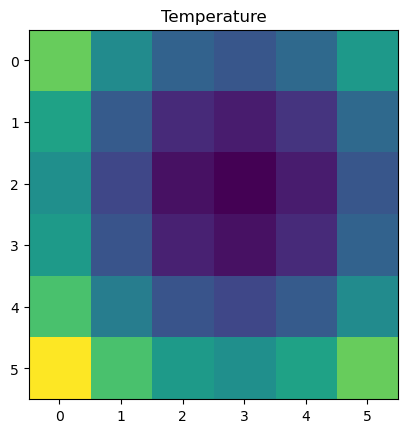

In [4]:
import matplotlib.pyplot as plt

Z1 =  np.abs(((X - 10) ** 2 + (Y - 10) ** 2) / 1 ** 2)
Z2 =  np.abs(((X + 10) ** 2 + (Y + 10) ** 2) / 2.5 ** 2)
Z =  (Z1 - Z2)

plt.imshow(Z)
plt.title("Temperature")
plt.show()

## Creating Raster Data

The final array `Z` still lacks a number of elements that transform it from being a non-spatial `numpy` array to a spatial one usable by `rasterio` etc. `Rasterio` requires the following elements to write out a geotif, or spatial raster dataset:

| Parameters     | Description    | Argument      |
| :---          | ---:           |---:        |
| driver  | the name of the desired format driver   |  `'GTiff'` |
| width  | the number of columns of the dataset   |  `Z.shape[1]` |
| height  | the number of rows of the dataset   |  `Z.shape[0]` |
| count  | a count of the dataset bands   |  `1` |
| dtype  | the data type of the dataset   |  `Z.dtype` |
| crs  | a coordinate reference system identifier or description   |  `'+proj=latlong'`|
| transform  | an affine transformation matrix   |  `Affine.translation(x[0] - xres / 2, y[0] - yres / 2) * Affine.scale(xres, yres)`|
| nodata  | a “nodata” value   |  `-9999`|

```{note}
`transform` defines the location of the upper left hand corner of the raster on the globe, and its spatial resolution. The arguments for `transform` are complex and beyond the scope of the chapter, please refer to the next chapter @ [affine transforms](d_affine.md) and [raster crs](d_raster_crs_intro.md) for more info. 
```
## Writing Rasters
To save this array along with spatial information to a file, we call `rasterio.open()` with a path to the new file to be created, and 'w' to specify writing mode, along with the arguments above.

In [5]:
import rasterio
from rasterio.transform import Affine
import datetime

# Use timestamp to create unique filename
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
output_file = f"../../pygis/temp/temperature_{timestamp}.tif"

# Your existing code with new filename
xres = (x[-1] - x[0]) / len(x)
yres = (y[-1] - y[0]) / len(y)

transform = Affine.translation(x[0] - xres / 2, y[0] - yres / 2) * Affine.scale(xres, yres)

with rasterio.open(
        output_file,  # Changed filename
        mode="w",
        driver="GTiff",
        height=Z.shape[0],
        width=Z.shape[1],
        count=1,
        dtype=Z.dtype,
        crs="+proj=latlong",
        transform=transform,
) as new_dataset:
        new_dataset.write(Z, 1)

print(f"Successfully created: {output_file}")

Successfully created: ../../pygis/temp/temperature_20250718_053632.tif


When we go to look again at our data we can read it back in using `open`. Before plotting we `raster.read(1)` the first band, which converts the data back to a `numpy` array that can be plotted in `matplotlib`.  Notice that we also specify the band number (in this case 1), with `.write(Z, 1)`.

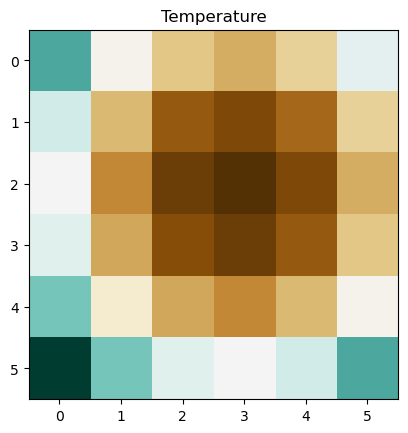

In [6]:
import matplotlib.pyplot as plt

raster = rasterio.open("../../pygis/temp/temperature.tif")

plt.imshow(raster.read(1), cmap="BrBG")
plt.title("Temperature")
plt.show()

So in summary, a spatial dataset is essentially just a `numpy.ndarray` with information about the location and resolution of the array, the [coordinate reference system](d_crs_what_is_it.md), and number of bands. This information is typically accessed and updated via the `.profile`.

In [7]:
print(raster.profile)

{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 6, 'height': 6, 'count': 1, 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'), 'transform': Affine(30.0, 0.0, -105.0,
       0.0, -30.0, 105.0), 'blockxsize': 6, 'blockysize': 6, 'tiled': False, 'interleave': 'band'}


## Update Raster Metadata
Notice the the `.profile` above is missing a meaningful `nodata` value and was uncompressed. Let's learn how to update these values. For this we can update the `.profile` dictionary.

In [8]:
# start with the original profile
profile = raster.profile
# update values for nodata and compression type
profile.update(nodata=0, compress="lzw")
print(profile)

{'driver': 'GTiff', 'dtype': 'float64', 'nodata': 0, 'width': 6, 'height': 6, 'count': 1, 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'), 'transform': Affine(30.0, 0.0, -105.0,
       0.0, -30.0, 105.0), 'blockxsize': 6, 'blockysize': 6, 'tiled': False, 'interleave': 'band', 'compress': 'lzw'}


Now we just need to write the array of data (obtained from `raster.read(1)`) out with the updated profile info. We can unpack all the dictionary values from the profile using `**profile`.

## Rasterio Multiband Rasters 
Working with multiband imagery starts to get a bit tricky, especially with `rasterio` alone. 

Let's start with a problematic raster file, a landsat image that stores its red, green, and blue bands in reverse order (blue, green, red), that is scaled by 100 (multiplied by 100 to store data as integers rather than float), and that is missing a meaningful nodata value.

In [9]:
with rasterio.open(
    "../../pygis/data/LC08_L1TP_224078_20200518_20200518_01_RT.TIF", mode="r", nodata=0) as src:
    # read in the array, band 3 first, then band 2, then band 1
    arr = src.read([3, 2, 1])
    # the array has three bands
    print("Array shape:", arr.shape)
    # look at the profile, despite setting nodata=0, there still isn't a nodata value 
    # this is because we need to update the profile and write out a new image with
    #  nodata set
    profile = src.profile
    print(profile)

Array shape: (3, 1860, 2041)
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 2041, 'height': 1860, 'count': 3, 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 21N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-57],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32621"]]'), 'transform': Affine(30.0, 0.0, 717345.0,
       0.0, -30.0, -2776995.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'pixel'}


```{note}
We use `src.read([3, 2, 1])` in order to reverse the read order of our bands. With this the original blue, green, red order is read in reverse as red, green, blue, which is required for true color images. 
```

To see what it looks like, let's use rasterio's `show` function which *sort of helps* when viewing multiband imagery.

Array shape: (3, 1860, 2041)
Data type: uint16
--------------


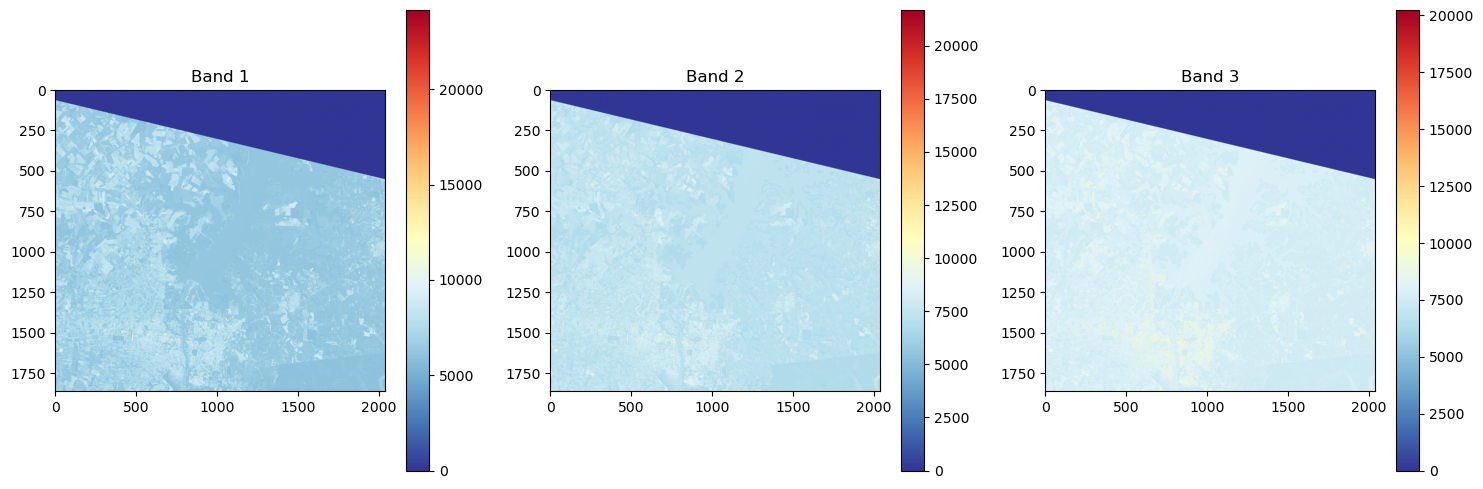

In [10]:
import matplotlib.pyplot as plt
import numpy as np

print(f"Array shape: {arr.shape}")
print(f"Data type: {arr.dtype}")
print('--------------')

# Display each band separately
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i in range(3):
    band = arr[i, :, :]  # Extract single band
    im = axes[i].imshow(band, cmap='RdYlBu_r')
    axes[i].set_title(f'Band {i+1}')
    plt.colorbar(im, ax=axes[i])

plt.tight_layout()
plt.show()

Arg... it looks terrible. A few things, the primary problem is that the zeros aren't being treated as missing data, and therefor messing everything up. Second, there is a message at the top of the image saying its `clipping... [0..255] for integers)`. 

Let's check what the range of values are in our raster. To do this we will use `scipy` `stats`, and `.ravel()` to convert our `n` dimension array to a `1d` array.

In [11]:
from scipy import stats

print(stats.describe(arr.ravel()))

DescribeResult(nobs=11388780, minmax=(np.uint16(0), np.uint16(24147)), mean=np.float64(6095.312502656123), variance=np.float64(7725568.744020711), skewness=np.float64(-1.6071105370358574), kurtosis=np.float64(0.9303298625510847))


Since we currently have integer data that ranges from 0 to 24147, we should try scaling it, if we go to the documentation we would see that we need to divide all values by 100.

In [12]:
scaled_arr = arr / 100
print(scaled_arr.dtype)

float64


Then let's write the data back out again with an updated profile. Notice that the datatype (`dtype`) has changed since we divided by 100.

In [13]:
# update the profile for the new raster
profile = src.profile
profile.update(nodata=0, compress="lzw", dtype=scaled_arr.dtype)

# write out raster as RGB 
with rasterio.open(
    "../../pygis/temp/LS_scaled_20200518.tif",
    mode="w",
    **profile,  # unpack the profile arguments set above
) as new_dataset:
    new_dataset.write(scaled_arr, [1, 2, 3])

ERROR 10: Pointer 'hObject' is NULL in 'GDALGetMetadata'.

ERROR 10: Pointer 'hObject' is NULL in 'GDALGetMetadata'.

ERROR 10: Pointer 'hObject' is NULL in 'GDALGetMetadata'.



```{note}
Since the bands have already been put in the right order in the array (ie. RGB), we can just write it out as follows `.write(scaled_arr, [1, 2, 3])`. 
```

There you go! A fixed raster. Try opening it in Qgis to make sure. We can look at it now using rasterio `show`, but again it isn't great, but better.

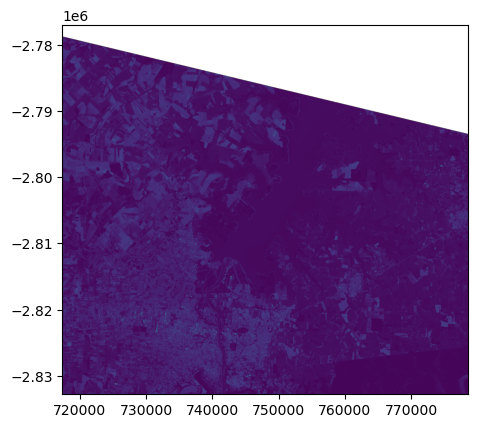

In [14]:
from rasterio.plot import show

with rasterio.open("../../pygis//temp/LS_scaled_20200518.tif", mode="r") as src:
   show(src, adjust='linear')

To help make all of this easier and more intuitive we will be presenting the use of `geowombat` for remote sensing applications later, [start here](f_rs_intro).

Just as a preview, here's how to do this in `geowombat`.

['blue' 'green' 'red']


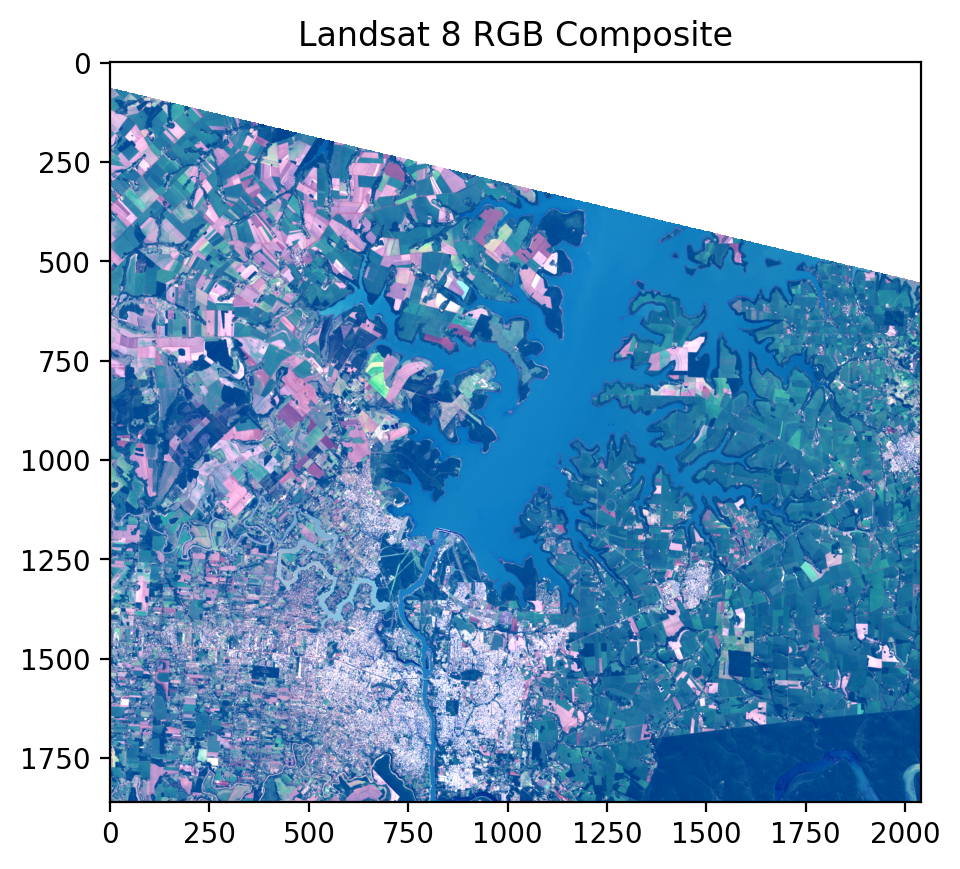

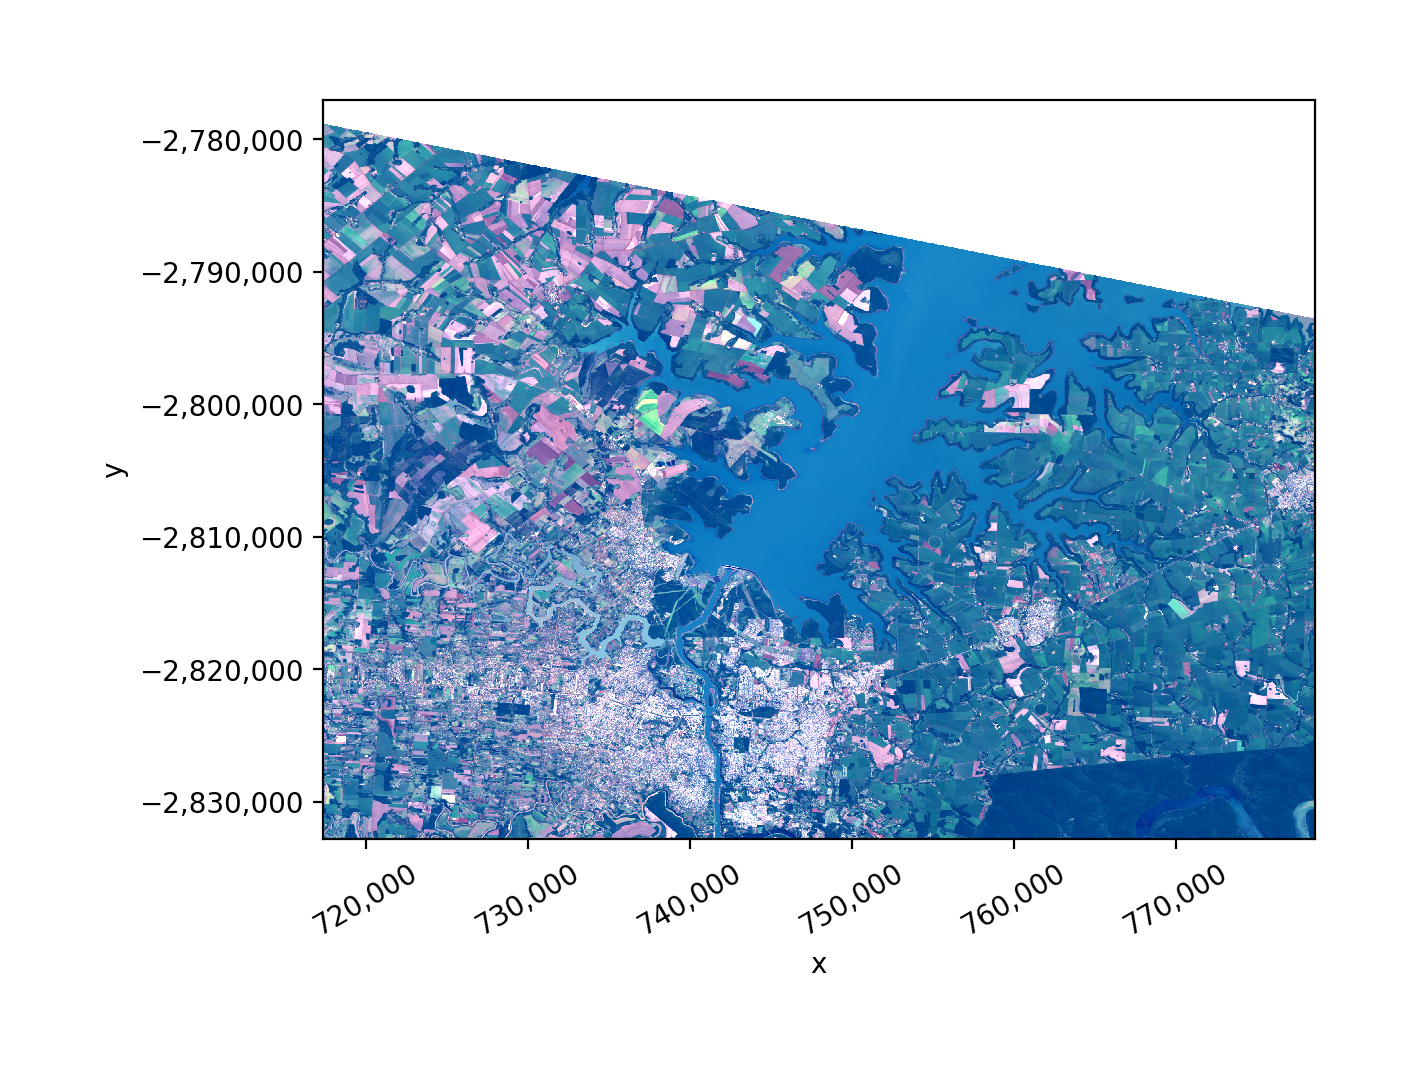

In [18]:
import rioxarray as rxr
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(dpi=200)

# Open the raster file with rioxarray
src = rxr.open_rasterio("../../pygis/data/LC08_L1TP_224078_20200518_20200518_01_RT.TIF")

# Assign band names (assuming it's a Landsat 8 image with bands 4,3,2 = RGB)
# For BGR sensor config, we'll assume bands are in Blue, Green, Red order
src = src.assign_coords(band=["blue", "green", "red"])

print(src.band.values)

# Remove 0 values and reorder bands to RGB
temp = src.where(src != 0).sel(band=["red", "green", "blue"])

# Plot using matplotlib with robust scaling (2-98 percentile)
temp_plot = temp.compute()  # Load data into memory for plotting
rgb_array = temp_plot.values.transpose(1, 2, 0)  # Transpose to (height, width, bands)

# Apply robust scaling (equivalent to robust=True in geowombat)
p2, p98 = np.percentile(rgb_array[rgb_array > 0], (2, 98))
rgb_scaled = np.clip((rgb_array - p2) / (p98 - p2), 0, 1)

ax.imshow(rgb_scaled)
ax.set_title("Landsat 8 RGB Composite")

# Save to file using rioxarray
temp.rio.to_raster(
    "../../pygis/temp/LS_scaled_20200518.tif", 
    compress='lzw',  # Add compression
    tiled=True       # Make it tiled for better performance
)
plt.show()


----------
Credits: [rasterio quickstart](https://rasterio.readthedocs.io/en/latest/quickstart.html)